In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
import sys
sys.path.append('/content/gdrive/MyDrive/Colab Notebooks/Neural Networks Project')

Mounted at /content/gdrive


In [ ]:
import torch
from torchvision import datasets, transforms
from torch import nn
import torch.nn.functional as F
import my_utils as mu
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

In [ ]:
data_path = './Data'
batch_size = 128  # 128

In [ ]:
transform = transforms.Compose([transforms.ToTensor()])

# Load training and test datasets
train_dataset = datasets.CIFAR10(root=data_path, train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root=data_path, train=False, download=True, transform=transform)

# Create data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

100%|██████████| 170498071/170498071 [00:04<00:00, 42504568.09it/s]


Extracting ./Data/cifar-10-python.tar.gz to ./Data
Files already downloaded and verified


**<=====================================================================>**
# My current approach
**<=====================================================================>**

In [ ]:
def evaluate_model(model, data_loader, device):
  """
  Evaluates the model on the given data loader.

  Args:
      model (nn.Module): The model to evaluate.
      data_loader (DataLoader): The data loader for the data (test or validation).
      device (torch.device): The device to use for evaluation (e.g., "cuda" for GPU).

  Returns:
      float: The accuracy of the model on the data.
  """

  model.eval()  # Set model to evaluation mode
  correct = 0
  total = 0

  with torch.no_grad():
    for images, labels in data_loader:
      images, labels = images.to(device), labels.to(device)
      outputs = model(images)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

  return correct / total

In [ ]:
def train_model(model, train_loader, test_loader, loss_fn, num_epochs, optimizer, device):
  model.to(device)
  train_loss_history = []
  train_acc_history = []
  test_acc_history = []

  for epoch in range(num_epochs):
    print(f"\nEpoch: {epoch+1}/{num_epochs}")

    # Training Loop
    model.train()
    train_loss = 0.0
    num_batches = 0
    correct = 0
    total = 0

    with tqdm(train_loader, unit="batch") as pbar:
      for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)

        # Forward Pass
        outputs = model(images)
        loss = loss_fn(outputs, labels)

        # Backward Pass and Update
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        num_batches += 1

        # Calculate training accuracy within the loop
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        pbar.set_postfix_str(f"Loss: {train_loss/num_batches:.4f}")

    train_loss_history.append(train_loss/num_batches)
    train_acc_history.append(correct / total)

    # Evaluation (optional)
    test_acc = evaluate_model(model, test_loader, device)
    test_acc_history.append(test_acc)
    print(f"Test Accuracy: {test_acc:.4f}")

  # Plot Train Loss, Train Accuracy and Test Accuracy
  plt.figure(figsize=(7, 5))
  plt.plot(train_loss_history, label="Train Loss")
  plt.plot(train_acc_history, label="Train Accuracy")
  plt.plot(test_acc_history, label="Test Accuracy")
  plt.xlabel("Epoch")
  plt.ylabel("Loss/Accuracy")  # Adjusted label for combined plot
  plt.title("Training Progress")
  plt.legend()
  plt.grid(True)
  plt.show()

  return train_loss_history, test_acc_history


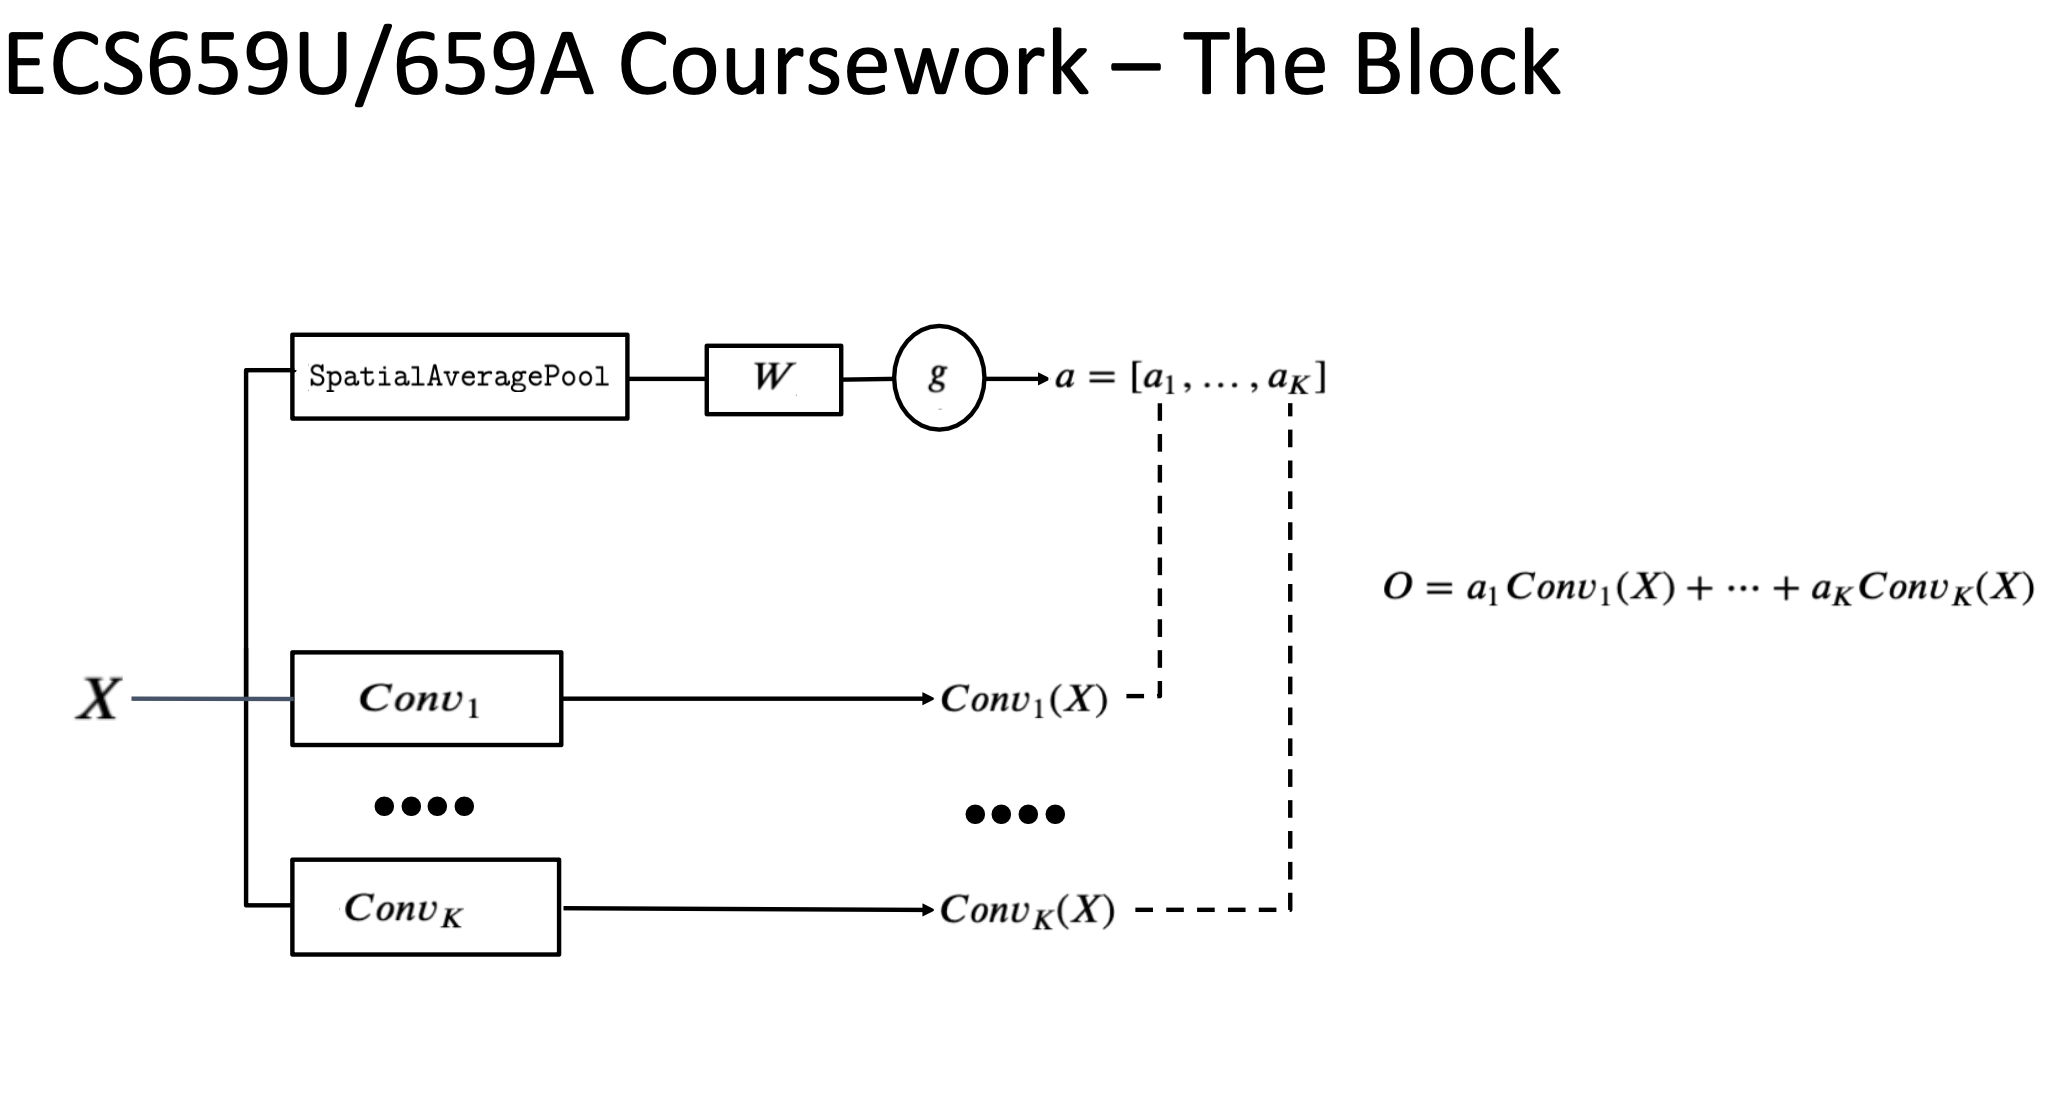


## The Model

In [ ]:
class CNN_Block(nn.Module):
    def __init__(self, input_channels, output_channels, n_convs):
        super(CNN_Block, self).__init__()
        self.input_channels = input_channels
        self.output_channels = output_channels
        self.n_convs = n_convs

        self.spatial_avg_pool = nn.AdaptiveAvgPool2d((1, 1))

        self.linear_a = nn.Linear(input_channels, n_convs)

        self.conv_layers = nn.ModuleList([nn.Conv2d(input_channels, output_channels, kernel_size=3, padding=1) for conv in range(n_convs)])

        self.relu = nn.ReLU(inplace=True)
        self.flatten = nn.Flatten()


    def forward(self, x):
        a = self.spatial_avg_pool(x)
        a = self.flatten(a)

        a = self.linear_a(a)
        a = self.relu(a)

        out = []
        for i in range(self.n_convs):
            out_i = self.conv_layers[i](x)  # Apply each conv to original data

            out_i = self.relu(out_i)
            out.append(out_i * a[0, i])

        out_final = torch.sum(torch.stack(out), dim=0)  # Combine outputs
        return out_final


In [ ]:
class SE_NET(nn.Module):
    def __init__(self, block_configs, channel_configs, n_classes=10):
        super(SE_NET, self).__init__()
        self.n_classes = n_classes

        # List to store the CNN blocks
        self.conv_blocks = nn.ModuleList([])

        # Input channels for the first block
        in_channels = 3

        # Create CNN blocks based on configurations
        for i, (num_convs, out_channels) in enumerate(zip(block_configs, channel_configs)):
            self.conv_blocks.append(CNN_Block(in_channels, out_channels, num_convs))
            in_channels = out_channels

        hidden_layer = int(in_channels/2)

        self.spatial_avg_pool = nn.AdaptiveAvgPool2d((1, 1))

        self.fc1 = nn.Linear(in_channels, int(in_channels/2))
        self.fc2 = nn.Linear(int(in_channels/2), n_classes)
        self.softmax = nn.Softmax(dim=1)
        self.flatten = nn.Flatten()
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        for block in self.conv_blocks:
            x = block(x)

        out = self.spatial_avg_pool(x)
        out = self.flatten(out)

        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)

        out = self.softmax(out)
        return out


In [ ]:
lr_01, lr_001, num_epochs_30, num_epochs_100  = 0.01, 0.001, 30, 100
loss_sn = nn.CrossEntropyLoss()

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #choose device: cpu or gpu
print('Using device:', device)

Using device: cuda


## My training function

1. The more convolutions the better
2. The more channels the better
3. Adam optimizer is superior

## model_4b_5_150

In [ ]:
model_4b_5_150 = SE_NET(block_configs=[5, 5, 5, 5], channel_configs=[10, 25, 50, 150]) # block_configs=[5, 5, 5, 5], channel_configs=[10, 40, 80, 160] 10, 25, 50, 100
print(model_4b_5_150)

In [ ]:
# Adam
optimizer_adam_001 = torch.optim.Adam(model_4b_5_150.parameters(), lr=lr_001)
optimizer_adam_01 = torch.optim.Adam(model_4b_5_150.parameters(), lr=lr_01)
# SDG
optimizer_sg_001 = torch.optim.SGD(model_4b_5_150.parameters(), lr=lr_001)
optimizer_sg_01 = torch.optim.SGD(model_4b_5_150.parameters(), lr=lr_01)

In [ ]:
train_model(model_4b_5_150, train_loader, test_loader, loss_sn, num_epochs_30, optimizer_adam_001, device)

In [ ]:
train_model(model_4b_5_150, train_loader, test_loader, loss_sn, num_epochs_30, optimizer_sg_001, device)

## model_3b_3_50

In [ ]:
model_3b_3_50 = SE_NET(block_configs=[3, 3, 3], channel_configs=[10, 25, 50])

In [ ]:
# Adam
optimizer_adam_001 = torch.optim.Adam(model_3b_3_50.parameters(), lr=lr_001)
optimizer_adam_01 = torch.optim.Adam(model_3b_3_50.parameters(), lr=lr_01)
# SDG
optimizer_sg_001 = torch.optim.SGD(model_3b_3_50.parameters(), lr=lr_001)
optimizer_sg_01 = torch.optim.SGD(model_3b_3_50.parameters(), lr=lr_01)

In [ ]:
train_model(model_3b_3_50, train_loader, test_loader, loss_sn, num_epochs_30, optimizer_adam_001, device) # FAIL

In [ ]:
train_model(model_3b_3_50, train_loader, test_loader, loss_sn, num_epochs_30, optimizer_adam_01, device) # FAIL

In [ ]:
train_model(model_3b_3_50, train_loader, test_loader, loss_sn, num_epochs_30, optimizer_sg_001, device) # FAIL

## model_3b_5_50

In [ ]:
model_3b_5_50 = SE_NET(block_configs=[5, 5, 5], channel_configs=[10, 25, 50])

In [ ]:
# Adam
optimizer_adam_001 = torch.optim.Adam(model_3b_5_50.parameters(), lr=lr_001)
optimizer_adam_01 = torch.optim.Adam(model_3b_5_50.parameters(), lr=lr_01)
# SDG
optimizer_sg_001 = torch.optim.SGD(model_3b_5_50.parameters(), lr=lr_001)
optimizer_sg_01 = torch.optim.SGD(model_3b_5_50.parameters(), lr=lr_01)

In [ ]:
train_model(model_3b_5_50, train_loader, test_loader, loss_sn, num_epochs_30, optimizer_adam_001, device) # Success 45.48%

In [ ]:
train_model(model_3b_5_50, train_loader, test_loader, loss_sn, num_epochs_30, optimizer_sg_001, device) # FAIL it doesn't learn

## model_3b_3_250

In [ ]:
model_3b_3_250 = SE_NET(block_configs=[3, 3, 3], channel_configs=[50, 100, 250])

In [ ]:
# Adam
optimizer_adam_001 = torch.optim.Adam(model_3b_3_250.parameters(), lr=lr_001)
optimizer_adam_01 = torch.optim.Adam(model_3b_3_250.parameters(), lr=lr_01)
# SDG
optimizer_sg_001 = torch.optim.SGD(model_3b_3_250.parameters(), lr=lr_001)
optimizer_sg_01 = torch.optim.SGD(model_3b_3_250.parameters(), lr=lr_01)

In [ ]:
train_model(model_3b_5_50, train_loader, test_loader, loss_sn, num_epochs_30, optimizer_adam_001, device) # FAIL

In [ ]:
train_model(model_3b_5_50, train_loader, test_loader, loss_sn, num_epochs_30, optimizer_sg_001, device) # FAIL

## model_3b_5_250

In [ ]:
model_3b_5_250 = SE_NET(block_configs=[5, 5, 5], channel_configs=[50, 100, 250])

In [ ]:
# Adam
optimizer_adam_001 = torch.optim.Adam(model_3b_5_250.parameters(), lr=lr_001)
optimizer_adam_01 = torch.optim.Adam(model_3b_5_250.parameters(), lr=lr_01)
# SDG
optimizer_sg_001 = torch.optim.SGD(model_3b_5_250.parameters(), lr=lr_001)
optimizer_sg_01 = torch.optim.SGD(model_3b_5_250.parameters(), lr=lr_01)


Epoch: 1/30


100%|██████████| 391/391 [01:09<00:00,  5.67batch/s, Loss: 2.2385]


Test Accuracy: 0.2186

Epoch: 2/30


100%|██████████| 391/391 [01:08<00:00,  5.69batch/s, Loss: 2.1998]


Test Accuracy: 0.2874

Epoch: 3/30


100%|██████████| 391/391 [01:08<00:00,  5.69batch/s, Loss: 2.1564]


Test Accuracy: 0.3196

Epoch: 4/30


100%|██████████| 391/391 [01:08<00:00,  5.69batch/s, Loss: 2.1281]


Test Accuracy: 0.3440

Epoch: 5/30


100%|██████████| 391/391 [01:08<00:00,  5.70batch/s, Loss: 2.1049]


Test Accuracy: 0.3383

Epoch: 6/30


100%|██████████| 391/391 [01:08<00:00,  5.70batch/s, Loss: 2.0849]


Test Accuracy: 0.3860

Epoch: 7/30


100%|██████████| 391/391 [01:08<00:00,  5.70batch/s, Loss: 2.0656]


Test Accuracy: 0.4007

Epoch: 8/30


100%|██████████| 391/391 [01:08<00:00,  5.71batch/s, Loss: 2.0593]


Test Accuracy: 0.4199

Epoch: 9/30


100%|██████████| 391/391 [01:08<00:00,  5.71batch/s, Loss: 2.0447]


Test Accuracy: 0.4329

Epoch: 10/30


100%|██████████| 391/391 [01:08<00:00,  5.71batch/s, Loss: 2.0264]


Test Accuracy: 0.4467

Epoch: 11/30


100%|██████████| 391/391 [01:08<00:00,  5.71batch/s, Loss: 2.0188]


Test Accuracy: 0.4603

Epoch: 12/30


100%|██████████| 391/391 [01:08<00:00,  5.71batch/s, Loss: 2.0056]


Test Accuracy: 0.4120

Epoch: 13/30


100%|██████████| 391/391 [01:08<00:00,  5.71batch/s, Loss: 1.9955]


Test Accuracy: 0.4467

Epoch: 14/30


100%|██████████| 391/391 [01:08<00:00,  5.71batch/s, Loss: 1.9888]


Test Accuracy: 0.4835

Epoch: 15/30


100%|██████████| 391/391 [01:08<00:00,  5.71batch/s, Loss: 1.9820]


Test Accuracy: 0.4844

Epoch: 16/30


100%|██████████| 391/391 [01:08<00:00,  5.72batch/s, Loss: 1.9708]


Test Accuracy: 0.4876

Epoch: 17/30


100%|██████████| 391/391 [01:08<00:00,  5.72batch/s, Loss: 1.9620]


Test Accuracy: 0.4968

Epoch: 18/30


100%|██████████| 391/391 [01:08<00:00,  5.72batch/s, Loss: 1.9554]


Test Accuracy: 0.5051

Epoch: 19/30


100%|██████████| 391/391 [01:08<00:00,  5.72batch/s, Loss: 1.9460]


Test Accuracy: 0.5163

Epoch: 20/30


100%|██████████| 391/391 [01:08<00:00,  5.72batch/s, Loss: 1.9390]


Test Accuracy: 0.5226

Epoch: 21/30


100%|██████████| 391/391 [01:08<00:00,  5.72batch/s, Loss: 1.9341]


Test Accuracy: 0.5335

Epoch: 22/30


100%|██████████| 391/391 [01:08<00:00,  5.72batch/s, Loss: 1.9240]


Test Accuracy: 0.5271

Epoch: 23/30


100%|██████████| 391/391 [01:08<00:00,  5.72batch/s, Loss: 1.9201]


Test Accuracy: 0.5288

Epoch: 24/30


100%|██████████| 391/391 [01:08<00:00,  5.72batch/s, Loss: 1.9122]


Test Accuracy: 0.5411

Epoch: 25/30


100%|██████████| 391/391 [01:08<00:00,  5.72batch/s, Loss: 1.9106]


Test Accuracy: 0.5109

Epoch: 26/30


100%|██████████| 391/391 [01:08<00:00,  5.72batch/s, Loss: 1.9070]


Test Accuracy: 0.5555

Epoch: 27/30


100%|██████████| 391/391 [01:08<00:00,  5.72batch/s, Loss: 1.8963]


Test Accuracy: 0.5389

Epoch: 28/30


100%|██████████| 391/391 [01:08<00:00,  5.72batch/s, Loss: 1.8916]


Test Accuracy: 0.5499

Epoch: 29/30


100%|██████████| 391/391 [01:08<00:00,  5.72batch/s, Loss: 1.8828]


Test Accuracy: 0.5686

Epoch: 30/30


100%|██████████| 391/391 [01:08<00:00,  5.72batch/s, Loss: 1.8786]


Test Accuracy: 0.5670


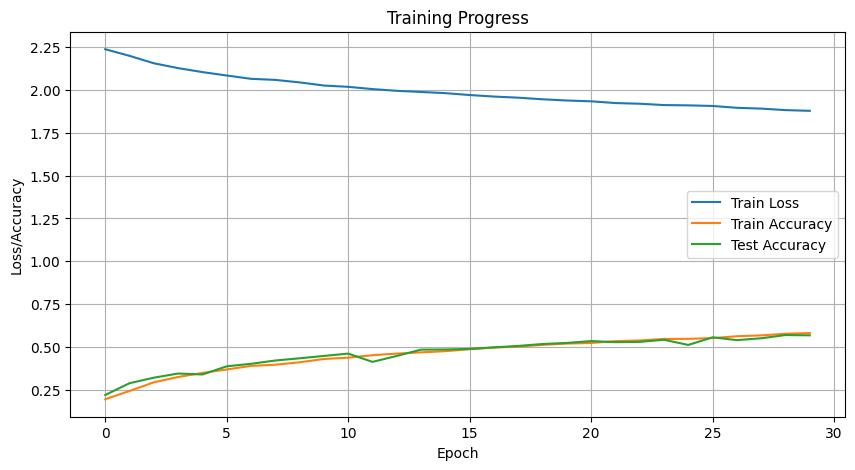

([2.238500786559356,
  2.199764090730711,
  2.156388641318397,
  2.1280978402823134,
  2.104932772838856,
  2.0849472735543997,
  2.065592119151064,
  2.059341076085025,
  2.044656817565489,
  2.026420735032357,
  2.018805149875943,
  2.0055886638134033,
  1.995502853332578,
  1.9887557532781226,
  1.9819512495299434,
  1.970846029498693,
  1.9619564982631323,
  1.9553744545982927,
  1.945998259517543,
  1.9389729893116086,
  1.9341426676191638,
  1.923991335322485,
  1.920076298896614,
  1.9121915473962379,
  1.910561902138888,
  1.9069713311427086,
  1.8962814631059652,
  1.8915531653577409,
  1.8828258675992335,
  1.8785843843084467],
 [0.2186,
  0.2874,
  0.3196,
  0.344,
  0.3383,
  0.386,
  0.4007,
  0.4199,
  0.4329,
  0.4467,
  0.4603,
  0.412,
  0.4467,
  0.4835,
  0.4844,
  0.4876,
  0.4968,
  0.5051,
  0.5163,
  0.5226,
  0.5335,
  0.5271,
  0.5288,
  0.5411,
  0.5109,
  0.5555,
  0.5389,
  0.5499,
  0.5686,
  0.567])

In [ ]:
train_model(model_3b_5_250, train_loader, test_loader, loss_sn, num_epochs_30, optimizer_adam_001, device) # Success 56.7%


Epoch: 1/70


100%|██████████| 391/391 [01:08<00:00,  5.69batch/s, Loss: 2.2575]


Test Accuracy: 0.2314

Epoch: 2/70


100%|██████████| 391/391 [01:08<00:00,  5.70batch/s, Loss: 2.2069]


Test Accuracy: 0.2416

Epoch: 3/70


100%|██████████| 391/391 [01:08<00:00,  5.70batch/s, Loss: 2.1669]


Test Accuracy: 0.3197

Epoch: 4/70


100%|██████████| 391/391 [01:08<00:00,  5.70batch/s, Loss: 2.1324]


Test Accuracy: 0.3373

Epoch: 5/70


100%|██████████| 391/391 [01:08<00:00,  5.71batch/s, Loss: 2.1033]


Test Accuracy: 0.3636

Epoch: 6/70


100%|██████████| 391/391 [01:08<00:00,  5.71batch/s, Loss: 2.0826]


Test Accuracy: 0.4000

Epoch: 7/70


100%|██████████| 391/391 [01:08<00:00,  5.70batch/s, Loss: 2.0625]


Test Accuracy: 0.4104

Epoch: 8/70


100%|██████████| 391/391 [01:08<00:00,  5.71batch/s, Loss: 2.0494]


Test Accuracy: 0.4185

Epoch: 9/70


100%|██████████| 391/391 [01:08<00:00,  5.71batch/s, Loss: 2.0297]


Test Accuracy: 0.4164

Epoch: 10/70


100%|██████████| 391/391 [01:08<00:00,  5.71batch/s, Loss: 2.0142]


Test Accuracy: 0.4648

Epoch: 11/70


100%|██████████| 391/391 [01:08<00:00,  5.71batch/s, Loss: 2.0000]


Test Accuracy: 0.3933

Epoch: 12/70


100%|██████████| 391/391 [01:08<00:00,  5.71batch/s, Loss: 1.9907]


Test Accuracy: 0.4669

Epoch: 13/70


100%|██████████| 391/391 [01:08<00:00,  5.72batch/s, Loss: 1.9811]


Test Accuracy: 0.4853

Epoch: 14/70


100%|██████████| 391/391 [01:08<00:00,  5.71batch/s, Loss: 1.9601]


Test Accuracy: 0.4941

Epoch: 15/70


100%|██████████| 391/391 [01:08<00:00,  5.71batch/s, Loss: 1.9538]


Test Accuracy: 0.4936

Epoch: 16/70


100%|██████████| 391/391 [01:08<00:00,  5.71batch/s, Loss: 1.9460]


Test Accuracy: 0.5239

Epoch: 17/70


100%|██████████| 391/391 [01:08<00:00,  5.72batch/s, Loss: 1.9371]


Test Accuracy: 0.4957

Epoch: 18/70


100%|██████████| 391/391 [01:08<00:00,  5.72batch/s, Loss: 1.9271]


Test Accuracy: 0.5248

Epoch: 19/70


100%|██████████| 391/391 [01:08<00:00,  5.72batch/s, Loss: 1.9250]


Test Accuracy: 0.5353

Epoch: 20/70


100%|██████████| 391/391 [01:08<00:00,  5.72batch/s, Loss: 1.9168]


Test Accuracy: 0.5415

Epoch: 21/70


100%|██████████| 391/391 [01:08<00:00,  5.72batch/s, Loss: 1.9097]


Test Accuracy: 0.5583

Epoch: 22/70


100%|██████████| 391/391 [01:08<00:00,  5.72batch/s, Loss: 1.9046]


Test Accuracy: 0.5678

Epoch: 23/70


100%|██████████| 391/391 [01:08<00:00,  5.72batch/s, Loss: 1.8956]


Test Accuracy: 0.5623

Epoch: 24/70


100%|██████████| 391/391 [01:08<00:00,  5.72batch/s, Loss: 1.8902]


Test Accuracy: 0.5680

Epoch: 25/70


100%|██████████| 391/391 [01:08<00:00,  5.72batch/s, Loss: 1.8861]


Test Accuracy: 0.5402

Epoch: 26/70


100%|██████████| 391/391 [01:08<00:00,  5.72batch/s, Loss: 1.8831]


Test Accuracy: 0.5807

Epoch: 27/70


100%|██████████| 391/391 [01:08<00:00,  5.72batch/s, Loss: 1.8806]


Test Accuracy: 0.5473

Epoch: 28/70


100%|██████████| 391/391 [01:08<00:00,  5.72batch/s, Loss: 1.8750]


Test Accuracy: 0.5703

Epoch: 29/70


100%|██████████| 391/391 [01:08<00:00,  5.72batch/s, Loss: 1.8653]


Test Accuracy: 0.5819

Epoch: 30/70


100%|██████████| 391/391 [01:08<00:00,  5.72batch/s, Loss: 1.8676]


Test Accuracy: 0.5756

Epoch: 31/70


100%|██████████| 391/391 [01:08<00:00,  5.72batch/s, Loss: 1.8647]


Test Accuracy: 0.5819

Epoch: 32/70


100%|██████████| 391/391 [01:08<00:00,  5.72batch/s, Loss: 1.8616]


Test Accuracy: 0.5503

Epoch: 33/70


100%|██████████| 391/391 [01:08<00:00,  5.72batch/s, Loss: 1.8611]


Test Accuracy: 0.5789

Epoch: 34/70


100%|██████████| 391/391 [01:08<00:00,  5.73batch/s, Loss: 1.8458]


Test Accuracy: 0.5893

Epoch: 35/70


100%|██████████| 391/391 [01:08<00:00,  5.72batch/s, Loss: 1.8445]


Test Accuracy: 0.6113

Epoch: 36/70


100%|██████████| 391/391 [01:08<00:00,  5.73batch/s, Loss: 1.8431]


Test Accuracy: 0.6035

Epoch: 37/70


100%|██████████| 391/391 [01:08<00:00,  5.72batch/s, Loss: 1.8378]


Test Accuracy: 0.6118

Epoch: 38/70


100%|██████████| 391/391 [01:08<00:00,  5.72batch/s, Loss: 1.8350]


Test Accuracy: 0.5871

Epoch: 39/70


100%|██████████| 391/391 [01:08<00:00,  5.73batch/s, Loss: 1.8420]


Test Accuracy: 0.6023

Epoch: 40/70


100%|██████████| 391/391 [01:08<00:00,  5.72batch/s, Loss: 1.8359]


Test Accuracy: 0.6094

Epoch: 41/70


100%|██████████| 391/391 [01:08<00:00,  5.72batch/s, Loss: 1.8286]


Test Accuracy: 0.5860

Epoch: 42/70


100%|██████████| 391/391 [01:08<00:00,  5.73batch/s, Loss: 1.8353]


Test Accuracy: 0.6205

Epoch: 43/70


100%|██████████| 391/391 [01:08<00:00,  5.72batch/s, Loss: 1.8255]


Test Accuracy: 0.5948

Epoch: 44/70


100%|██████████| 391/391 [01:08<00:00,  5.73batch/s, Loss: 1.8232]


Test Accuracy: 0.6228

Epoch: 45/70


100%|██████████| 391/391 [01:08<00:00,  5.73batch/s, Loss: 1.8250]


Test Accuracy: 0.6258

Epoch: 46/70


100%|██████████| 391/391 [01:08<00:00,  5.72batch/s, Loss: 1.8143]


Test Accuracy: 0.6235

Epoch: 47/70


100%|██████████| 391/391 [01:08<00:00,  5.73batch/s, Loss: 1.8220]


Test Accuracy: 0.6396

Epoch: 48/70


100%|██████████| 391/391 [01:08<00:00,  5.73batch/s, Loss: 1.8076]


Test Accuracy: 0.6196

Epoch: 49/70


100%|██████████| 391/391 [01:08<00:00,  5.72batch/s, Loss: 1.8129]


Test Accuracy: 0.6229

Epoch: 50/70


100%|██████████| 391/391 [01:08<00:00,  5.73batch/s, Loss: 1.8102]


Test Accuracy: 0.6379

Epoch: 51/70


100%|██████████| 391/391 [01:08<00:00,  5.73batch/s, Loss: 1.8011]


Test Accuracy: 0.6397

Epoch: 52/70


100%|██████████| 391/391 [01:08<00:00,  5.73batch/s, Loss: 1.8023]


Test Accuracy: 0.6382

Epoch: 53/70


100%|██████████| 391/391 [01:08<00:00,  5.73batch/s, Loss: 1.8072]


Test Accuracy: 0.6143

Epoch: 54/70


100%|██████████| 391/391 [01:08<00:00,  5.72batch/s, Loss: 1.8026]


Test Accuracy: 0.6403

Epoch: 55/70


100%|██████████| 391/391 [01:08<00:00,  5.73batch/s, Loss: 1.7954]


Test Accuracy: 0.6206

Epoch: 56/70


100%|██████████| 391/391 [01:08<00:00,  5.73batch/s, Loss: 1.7958]


Test Accuracy: 0.6333

Epoch: 57/70


100%|██████████| 391/391 [01:08<00:00,  5.73batch/s, Loss: 1.7932]


Test Accuracy: 0.6193

Epoch: 58/70


100%|██████████| 391/391 [01:08<00:00,  5.73batch/s, Loss: 1.7912]


Test Accuracy: 0.6265

Epoch: 59/70


100%|██████████| 391/391 [01:08<00:00,  5.73batch/s, Loss: 1.7870]


Test Accuracy: 0.6397

Epoch: 60/70


100%|██████████| 391/391 [01:08<00:00,  5.73batch/s, Loss: 1.7841]


Test Accuracy: 0.6223

Epoch: 61/70


100%|██████████| 391/391 [01:08<00:00,  5.73batch/s, Loss: 1.7874]


Test Accuracy: 0.6468

Epoch: 62/70


100%|██████████| 391/391 [01:08<00:00,  5.73batch/s, Loss: 1.7820]


Test Accuracy: 0.6638

Epoch: 63/70


100%|██████████| 391/391 [01:08<00:00,  5.73batch/s, Loss: 1.7787]


Test Accuracy: 0.6583

Epoch: 64/70


100%|██████████| 391/391 [01:08<00:00,  5.73batch/s, Loss: 1.7780]


Test Accuracy: 0.6681

Epoch: 65/70


100%|██████████| 391/391 [01:08<00:00,  5.73batch/s, Loss: 1.7775]


Test Accuracy: 0.6579

Epoch: 66/70


100%|██████████| 391/391 [01:08<00:00,  5.73batch/s, Loss: 1.7847]


Test Accuracy: 0.6161

Epoch: 67/70


100%|██████████| 391/391 [01:08<00:00,  5.73batch/s, Loss: 1.7784]


Test Accuracy: 0.6193

Epoch: 68/70


100%|██████████| 391/391 [01:08<00:00,  5.73batch/s, Loss: 1.7675]


Test Accuracy: 0.6554

Epoch: 69/70


100%|██████████| 391/391 [01:08<00:00,  5.73batch/s, Loss: 1.7783]


Test Accuracy: 0.6641

Epoch: 70/70


100%|██████████| 391/391 [01:08<00:00,  5.73batch/s, Loss: 1.7708]


Test Accuracy: 0.6380


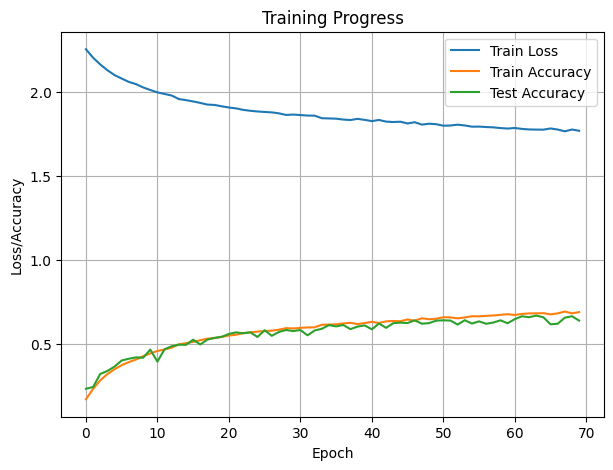

([2.257548741367467,
  2.2069060351232737,
  2.166881042978038,
  2.1323876920563487,
  2.1033264069301087,
  2.0825660576295975,
  2.062472880648835,
  2.0493769993257644,
  2.0296964428918747,
  2.0142496263279632,
  2.000042794000767,
  1.9906815692896733,
  1.981073684094812,
  1.9601281799013963,
  1.9537578665691873,
  1.9459571179831425,
  1.9371270727928338,
  1.9271303034194596,
  1.9250052719164992,
  1.9168337985987554,
  1.9097161762549748,
  1.9045606680843226,
  1.8956341993473376,
  1.8901639350539887,
  1.8860747701371723,
  1.8830665374350974,
  1.8806320727633699,
  1.8749738489575398,
  1.8653111652949887,
  1.8676207687543787,
  1.8647229104395717,
  1.8616296077323387,
  1.861103543540096,
  1.8458035632472514,
  1.8444707576576096,
  1.8430714875535892,
  1.8377940209625323,
  1.8350005759607495,
  1.8419864994790547,
  1.8358692442974471,
  1.8285767666214263,
  1.8353235898420328,
  1.825540940474976,
  1.8231678185865396,
  1.8249614668624174,
  1.8143412731492

In [ ]:
train_model(model_3b_5_250, train_loader, test_loader, loss_sn, 70, optimizer_adam_001, device) # 63.8%

In [ ]:
optimizer_adam_0001 = torch.optim.Adam(model_3b_5_250.parameters(), lr=0.0001)

In [ ]:
optimizer_adam_0006 = torch.optim.Adam(model_3b_5_250.parameters(), lr=0.0006)

In [ ]:
# SDG
optimizer_sg_001 = torch.optim.SGD(model_3b_5_250.parameters(), lr=lr_001)

In [ ]:
train_model(model_3b_5_250, train_loader, test_loader, loss_sn, 30, optimizer_sg_001, device) # 0.0001 - 12 epochs don, 69.41%, 70.64%


Epoch: 1/30


100%|██████████| 391/391 [01:08<00:00,  5.73batch/s, Loss: 1.7067]


Test Accuracy: 0.6981

Epoch: 2/30


100%|██████████| 391/391 [01:08<00:00,  5.74batch/s, Loss: 1.7008]


Test Accuracy: 0.6997

Epoch: 3/30


100%|██████████| 391/391 [01:08<00:00,  5.74batch/s, Loss: 1.6981]


Test Accuracy: 0.6976

Epoch: 4/30


100%|██████████| 391/391 [01:08<00:00,  5.73batch/s, Loss: 1.6962]


Test Accuracy: 0.7001

Epoch: 5/30


100%|██████████| 391/391 [01:08<00:00,  5.74batch/s, Loss: 1.6949]


Test Accuracy: 0.7018

Epoch: 6/30


100%|██████████| 391/391 [01:08<00:00,  5.73batch/s, Loss: 1.6944]


Test Accuracy: 0.7050

Epoch: 7/30


100%|██████████| 391/391 [01:08<00:00,  5.74batch/s, Loss: 1.6936]


Test Accuracy: 0.7052

Epoch: 8/30


100%|██████████| 391/391 [01:08<00:00,  5.74batch/s, Loss: 1.6927]


Test Accuracy: 0.7039

Epoch: 9/30


100%|██████████| 391/391 [01:08<00:00,  5.74batch/s, Loss: 1.6922]


Test Accuracy: 0.7038

Epoch: 10/30


100%|██████████| 391/391 [01:08<00:00,  5.74batch/s, Loss: 1.6920]


Test Accuracy: 0.7034

Epoch: 11/30


100%|██████████| 391/391 [01:08<00:00,  5.74batch/s, Loss: 1.6917]


Test Accuracy: 0.7022

Epoch: 12/30


100%|██████████| 391/391 [01:08<00:00,  5.74batch/s, Loss: 1.6917]


Test Accuracy: 0.7056

Epoch: 13/30


100%|██████████| 391/391 [01:08<00:00,  5.74batch/s, Loss: 1.6909]


Test Accuracy: 0.7056

Epoch: 14/30


100%|██████████| 391/391 [01:08<00:00,  5.73batch/s, Loss: 1.6904]


Test Accuracy: 0.7046

Epoch: 15/30


100%|██████████| 391/391 [01:08<00:00,  5.73batch/s, Loss: 1.6898]


Test Accuracy: 0.7058

Epoch: 16/30


100%|██████████| 391/391 [01:08<00:00,  5.74batch/s, Loss: 1.6897]


Test Accuracy: 0.7045

Epoch: 17/30


100%|██████████| 391/391 [01:08<00:00,  5.74batch/s, Loss: 1.6894]


Test Accuracy: 0.7044

Epoch: 18/30


100%|██████████| 391/391 [01:08<00:00,  5.73batch/s, Loss: 1.6889]


Test Accuracy: 0.7064

Epoch: 19/30


  2%|▏         | 6/391 [00:01<01:24,  4.58batch/s, Loss: 1.6760]


KeyboardInterrupt: 

In [ ]:
train_model(model_3b_5_250, train_loader, test_loader, loss_sn, num_epochs_30, optimizer_adam_01, device) # Fail

In [ ]:
torch.save(model_3b_5_250.state_dict(), "final_model_3b_5_250.pth")

In [ ]:
# Later, to retrain the model:
retrain_model = SE_NET_reloaded()  # Create a new instance of your model architecture

# Load the saved state dictionary (weights and architecture)
retrain_model.load_state_dict(torch.load("model.pth"))

# Now you can use 'retrain_model' for further training with additional data

## model_3b_10_250

In [ ]:
model_3b_10_250 = SE_NET(block_configs=[10, 10, 10], channel_configs=[50, 100, 250])

In [ ]:
# Adam
optimizer_adam_001 = torch.optim.Adam(model_3b_10_250.parameters(), lr=lr_001)
optimizer_adam_01 = torch.optim.Adam(model_3b_10_250.parameters(), lr=lr_01)

In [ ]:
train_model(model_3b_10_250, train_loader, test_loader, loss_sn, num_epochs_30, optimizer_adam_001, device) # It is ok 52.56%


Epoch: 1/30


100%|██████████| 391/391 [02:13<00:00,  2.93batch/s, Loss: 2.2835]


Test Accuracy: 0.2234

Epoch: 2/30


100%|██████████| 391/391 [02:13<00:00,  2.93batch/s, Loss: 2.2204]


Test Accuracy: 0.2281

Epoch: 3/30


100%|██████████| 391/391 [02:13<00:00,  2.93batch/s, Loss: 2.2093]


Test Accuracy: 0.2389

Epoch: 4/30


100%|██████████| 391/391 [02:13<00:00,  2.93batch/s, Loss: 2.1935]


Test Accuracy: 0.2887

Epoch: 5/30


100%|██████████| 391/391 [02:13<00:00,  2.93batch/s, Loss: 2.1666]


Test Accuracy: 0.2998

Epoch: 6/30


100%|██████████| 391/391 [02:13<00:00,  2.93batch/s, Loss: 2.1359]


Test Accuracy: 0.3386

Epoch: 7/30


100%|██████████| 391/391 [02:13<00:00,  2.93batch/s, Loss: 2.1107]


Test Accuracy: 0.3703

Epoch: 8/30


100%|██████████| 391/391 [02:13<00:00,  2.93batch/s, Loss: 2.0886]


Test Accuracy: 0.3871

Epoch: 9/30


100%|██████████| 391/391 [02:13<00:00,  2.93batch/s, Loss: 2.0659]


Test Accuracy: 0.4124

Epoch: 10/30


100%|██████████| 391/391 [02:13<00:00,  2.93batch/s, Loss: 2.0556]


Test Accuracy: 0.4091

Epoch: 11/30


100%|██████████| 391/391 [02:13<00:00,  2.93batch/s, Loss: 2.0414]


Test Accuracy: 0.4135

Epoch: 12/30


100%|██████████| 391/391 [02:13<00:00,  2.93batch/s, Loss: 2.0317]


Test Accuracy: 0.4253

Epoch: 13/30


100%|██████████| 391/391 [02:13<00:00,  2.93batch/s, Loss: 2.0226]


Test Accuracy: 0.4302

Epoch: 14/30


100%|██████████| 391/391 [02:13<00:00,  2.93batch/s, Loss: 2.0163]


Test Accuracy: 0.4466

Epoch: 15/30


100%|██████████| 391/391 [02:13<00:00,  2.93batch/s, Loss: 2.0095]


Test Accuracy: 0.4478

Epoch: 16/30


100%|██████████| 391/391 [02:13<00:00,  2.93batch/s, Loss: 2.0026]


Test Accuracy: 0.4591

Epoch: 17/30


100%|██████████| 391/391 [02:13<00:00,  2.93batch/s, Loss: 1.9927]


Test Accuracy: 0.4572

Epoch: 18/30


100%|██████████| 391/391 [02:13<00:00,  2.94batch/s, Loss: 1.9802]


Test Accuracy: 0.4440

Epoch: 19/30


100%|██████████| 391/391 [02:13<00:00,  2.94batch/s, Loss: 1.9754]


Test Accuracy: 0.4583

Epoch: 20/30


100%|██████████| 391/391 [02:13<00:00,  2.93batch/s, Loss: 1.9679]


Test Accuracy: 0.5051

Epoch: 21/30


100%|██████████| 391/391 [02:13<00:00,  2.94batch/s, Loss: 1.9631]


Test Accuracy: 0.5037

Epoch: 22/30


100%|██████████| 391/391 [02:13<00:00,  2.94batch/s, Loss: 1.9540]


Test Accuracy: 0.4377

Epoch: 23/30


100%|██████████| 391/391 [02:12<00:00,  2.94batch/s, Loss: 1.9479]


Test Accuracy: 0.5003

Epoch: 24/30


100%|██████████| 391/391 [02:13<00:00,  2.94batch/s, Loss: 1.9452]


Test Accuracy: 0.4871

Epoch: 25/30


100%|██████████| 391/391 [02:13<00:00,  2.94batch/s, Loss: 1.9383]


Test Accuracy: 0.5059

Epoch: 26/30


100%|██████████| 391/391 [02:13<00:00,  2.94batch/s, Loss: 1.9339]


Test Accuracy: 0.5256

Epoch: 27/30


 44%|████▍     | 173/391 [00:59<01:14,  2.92batch/s, Loss: 1.9309]


KeyboardInterrupt: 

In [ ]:
train_model(model_3b_10_250, train_loader, test_loader, loss_sn, num_epochs_30, optimizer_adam_01, device) # FAIL